# Bootstrapping

#### Import packages

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [71]:
random.seed(100)

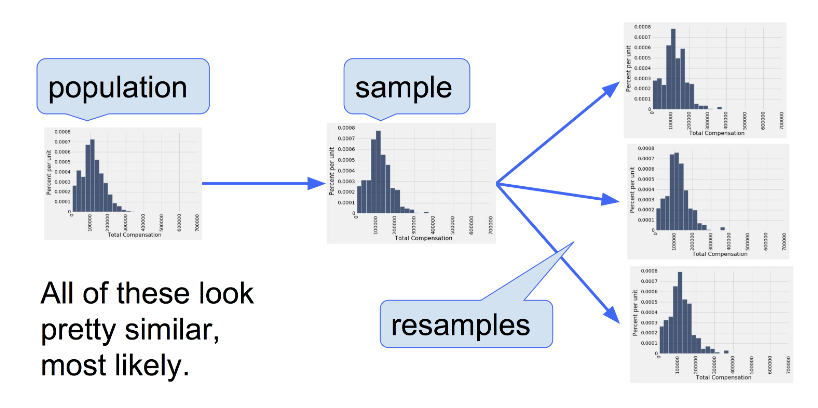

#### A/B Testing Example

In [72]:
data = pd.read_csv("AB_Test_Results.csv")

In [73]:
data

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


A/B testing is a randomized experimentation process that consists of a randomized experiment with two variants, A and B. In our data, the two groups are called variant and control. The revenue column shows how much revenue is attributed to each customer. 

We want to know if the mean revenue is significantly higher with either the variant or control group. Assuming that the data is collected in a manner that is randomized and unbiased, we perform bootstrapping on the sample to estimate the population means of the variant group and the control group.

### EDA

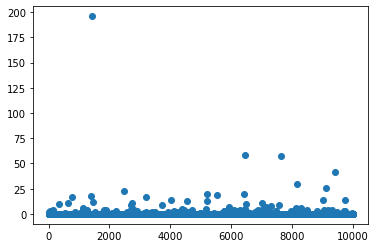

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
x = data['REVENUE']
plt.scatter(x.index, x)
plt.show()

We decided to first continue with the original data and asses performance before removing it. Don't worry, we will remove this point at the end and see how it affects our results. 

#### A sparse dataset

In [75]:
len(data[data['REVENUE'] != 0])

152

In [76]:
152/len(data)

0.0152

We can see that the dataset is sparse, meaning there are a lot of values that are 0, and only about 1.5% that are nonzero. Since so many of the values are 0, random sampling with replacement will often choose 0, resulting in varying results. Typically, we don't want to use bootstrapping on a sparse dataset, but there are things we can do to remedy this. First, let's try bootstrapping directly on the sparse dataset.

### A/B testing dataset: split into 2 datasets: variant and control

#### Split into variant and control groups

In [77]:
variant = data[data['VARIANT_NAME'] == 'variant']
control = data[data['VARIANT_NAME'] == 'control']

We will perform bootstrapping on each group and compare the means to see if there is a significant difference.

### Bootstrapping on variant group
#### Split variant group into train and test

In [78]:
x_1, x_2, variant_train, variant_test = train_test_split(variant['USER_ID'],
                                                         variant['REVENUE'],
                                                         random_state=20,
                                                         train_size=.7)

#### Create 1000 bags of same size as training dataset.

In [79]:
variant_sample_mean = []

for i in range(1000):
    y = random.choices(variant_train.tolist(), k=len(variant_train))
    mean = np.mean(y)
    variant_sample_mean.append(mean)

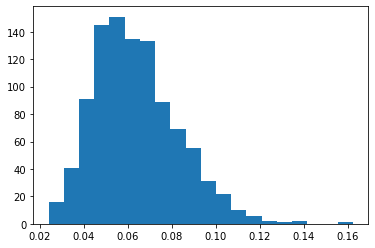

In [135]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(variant_sample_mean, bins=20)
plt.show()

In [82]:
np.mean(variant_sample_mean)

0.06367095129592709

In [83]:
np.mean(variant_test)

0.0866910299003322

### Bootstrapping on control group
#### Split control group into train and test

In [85]:
x_1, x_2, control_train, control_test = train_test_split(control['USER_ID'],
                                                         control['REVENUE'],
                                                         random_state=20,
                                                         train_size=.7)

#### Create 1000 bags of same size as training dataset

In [86]:
control_sample_mean = []

for i in range(1000):
    y = random.choices(control_train.tolist(), k=len(control_train))
    mean = np.mean(y)
    control_sample_mean.append(mean)

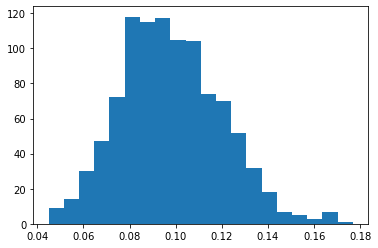

In [90]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(control_sample_mean, bins=20)
plt.show()

In [91]:
np.mean(control_sample_mean)

0.09808093176605505

In [92]:
np.mean(control_test)

0.20322192513368986

We can see that there is quite a large difference in the train and test sets. This is because most of the data is 0, which heavily affects our random selection with replacement.

To deal with this problem, we try sampling proportionally from two distributions: the zero distribution and the nonzero distribution.

# Sampling Separately

This method is used to sample specific proportions of zero and nonzero data points that represent the original sample. This technique is meant to ensure that the bagged samples will be representative of the population of interest. 

#### Variant group: split into nonzero and zero 

We split the variant group into nonzero and zero parts and sample proportionally.

In [93]:
dist_nonzero = variant[variant['REVENUE'] != 0]
dist_zero = variant[variant['REVENUE'] == 0]

#### Creating Train Test Split while keeping correct proportion

In [94]:
x1, x2, nonzero_train, nonzero_test = train_test_split(dist_nonzero['USER_ID'],
                                                       dist_nonzero['REVENUE'],
                                                       random_state=20,
                                                       train_size=.7)

In [95]:
x_1, x_2, zero_train, zero_test = train_test_split(dist_zero['USER_ID'],
                                                   dist_zero['REVENUE'],
                                                   random_state=20,
                                                   train_size=.7)

In [96]:
combined_train_variant = pd.concat([nonzero_train, zero_train], axis=0)
combined_test_variant = pd.concat([nonzero_test, zero_test], axis=0)

Now we have our train and test sets for the variant group.

#### Bootstrapping for the variant

In [97]:
combined_train_sample_mean = []
for i in range(1000):
    y = random.choices(combined_train_variant.tolist(),
                       k=len(combined_train_variant))
    mean = np.mean(y)
    combined_train_sample_mean.append(mean)

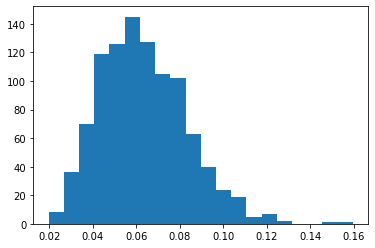

In [101]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(combined_train_sample_mean, bins=20)
plt.show()

In [102]:
np.mean(combined_train_sample_mean)

0.06349893732193732

In [103]:
np.mean(combined_test_variant)

0.08389110225763613

This is about the same as before (slightly better): 0.023 vs 0.020.

#### Control group: split into nonzero and zero

In [104]:
dist_nonzero = control[control['REVENUE'] != 0]
dist_zero = control[control['REVENUE'] == 0]

#### Creating Train Test Split while keeping correct proportion

In [105]:
x1, x2, nonzero_train, nonzero_test = train_test_split(dist_nonzero['USER_ID'],
                                                       dist_nonzero['REVENUE'],
                                                       random_state=20,
                                                       train_size=.7)

In [106]:
x_1, x_2, zero_train, zero_test = train_test_split(dist_zero['USER_ID'],
                                                   dist_zero['REVENUE'],
                                                   random_state=20,
                                                   train_size=.7)

In [107]:
combined_train_control = pd.concat([nonzero_train, zero_train], axis=0)
combined_test_control = pd.concat([nonzero_test, zero_test], axis=0)

Now we have our control train and test sets.

#### Bootstrapping for the control

In [108]:
combined_train_sample_mean = []
for i in range(1000):
    y = random.choices(combined_train_control.tolist(),
                       k=len(combined_train_control))
    mean = np.mean(y)
    combined_train_sample_mean.append(mean)

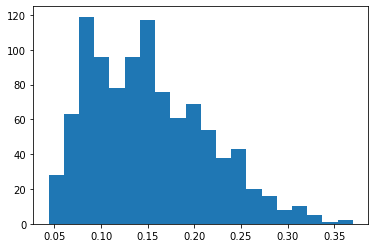

In [109]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(combined_train_sample_mean, bins=20)
plt.show()

In [110]:
np.mean(combined_train_sample_mean)

0.15156092889908257

In [111]:
np.mean(combined_test_control)

0.0900735294117647

This is better than before (0.061 difference compared to 0.105), but we can still do better.

Let's try upsampling -- taking bagged samples that are much bigger than the original. Notice we are still sampling proportionally from our 2 distributions.

# Upsampling

In the following examples, we combine the previous technique with upsampling, and create bagged samples that are 5 times the size of the original data.

#### Bootstrapping for Variant with upsampling

In [112]:
combined_train_sample_mean = []
for i in range(1000):
    y = random.choices(combined_train_variant.tolist(),
                       k=5*len(combined_train_variant))
    mean = np.mean(y)
    combined_train_sample_mean.append(mean)

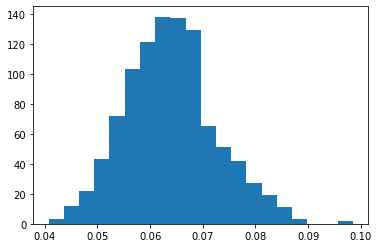

In [113]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(combined_train_sample_mean, bins=20)
plt.show()

In [114]:
np.mean(combined_train_sample_mean)

0.06392547635327635

In [115]:
np.mean(combined_test_variant)

0.08389110225763613

#### Bootstrapping for Control with upsampling

In [118]:
control_sample_mean = []

for i in range(1000):
    y = random.choices(control_train.tolist(), k=5*len(control_train))
    mean = np.mean(y)
    control_sample_mean.append(mean)

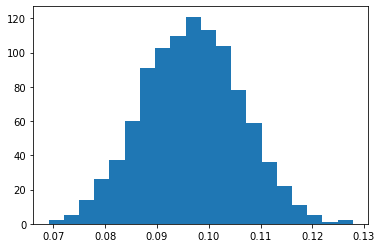

In [119]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(control_sample_mean, bins=20)
plt.show()

In [120]:
np.mean(control_sample_mean)

0.09678636066513763

In [121]:
np.mean(combined_test_control)

0.0900735294117647

#### From bootstrapping, we can see that the control group has a higher mean revenue than the variant group. In practical A/B testing, we want to statistically check if one group is better.

### Outliers and Influential points

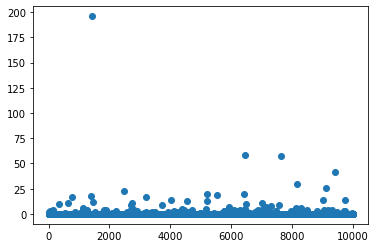

In [122]:
fig, ax = plt.subplots(figsize=(6, 4))
x = data['REVENUE']
plt.scatter(x.index, x)
plt.show()

In [123]:
data['REVENUE'].sort_values().tail()

8168     29.32
9421     41.53
7642     57.46
6447     58.63
1437    196.01
Name: REVENUE, dtype: float64

### Create a new subset without the point near y=200

In [124]:
subset = data.drop(1437)

### variant group

In [125]:
variant = subset[subset['VARIANT_NAME'] == 'variant']

In [126]:
dist_nonzero = variant[variant['REVENUE'] != 0]
dist_zero = variant[variant['REVENUE'] == 0]
x1, x2, nonzero_train, nonzero_test = train_test_split(dist_nonzero['USER_ID'],
                                                       dist_nonzero['REVENUE'],
                                                       random_state=20,
                                                       train_size=.7)
x1, x2, zero_train, zero_test = train_test_split(dist_zero['USER_ID'],
                                                 dist_zero['REVENUE'],
                                                 random_state=20,
                                                 train_size=.7)
combined_train_variant = pd.concat([nonzero_train, zero_train], axis=0)
combined_test_variant = pd.concat([nonzero_test, zero_test], axis=0)

### Results of variant

In [127]:
combined_train_sample_mean = []
for i in range(1000):
    y = random.choices(combined_train_variant.tolist(),
                       k=5*len(combined_train_variant))
    mean = np.mean(y)
    combined_train_sample_mean.append(mean)

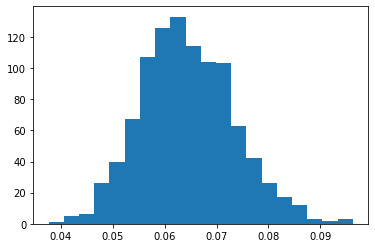

In [128]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(combined_train_sample_mean, bins=20)
plt.show()

In [129]:
np.mean(combined_train_sample_mean)

0.06439502165242164

In [130]:
np.mean(combined_test_variant)

0.08389110225763613

### control group

In [131]:
control = subset[subset['VARIANT_NAME'] == 'control']
dist_nonzero = control[control['REVENUE'] != 0]
dist_zero = control[control['REVENUE'] == 0]
x1, x2, nonzero_train, nonzero_test = train_test_split(dist_nonzero['USER_ID'],
                                                       dist_nonzero['REVENUE'],
                                                       random_state=20,
                                                       train_size=.7)
x1, x2, zero_train, zero_test = train_test_split(dist_zero['USER_ID'],
                                                 dist_zero['REVENUE'],
                                                 random_state=20,
                                                 train_size=.7)
combined_train_control = pd.concat([nonzero_train, zero_train], axis=0)
combined_test_control = pd.concat([nonzero_test, zero_test], axis=0)
combined_train_sample_mean = []
for i in range(1000):
    y = random.choices(combined_train_control.tolist(),
                       k=5*len(combined_train_control))
    mean = np.mean(y)
    combined_train_sample_mean.append(mean)

### results of control

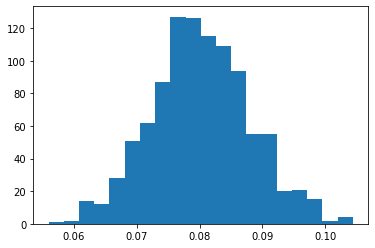

In [132]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(combined_train_sample_mean, bins=20)
plt.show()

In [133]:
np.mean(combined_train_sample_mean)

0.08024684944078003

In [134]:
np.mean(combined_test_control)

0.11225267379679144

# Takeaways
- Bootstrapping doesn't always work well on sparse datasets
- There are many ways to modify bootstrapping -- split into distributions, upsampling, removing influential points
- Keep in mind that because we set a random state for our train/test split, the data will be split in the same (random) way, but it is possible that if the data is split differently, this will affect our results.
- A possible remedy would be to split the datset many different ways, and then perform bootstrapping on all of those different train/test splits, and find the mean of that. However, this is too computationally expensive for our purposes today.